# Распознавание лиц

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import cv2

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torch.nn import functional
from torch import linalg

import torchvision
from torchvision import transforms

%matplotlib inline

In [2]:
'cuda' if torch.cuda.is_available() else 'cpu'

'cuda'

## Датасет

Я взял часть открытого датасета [celebA](https://colab.research.google.com/corgiredirector?site=https%3A%2F%2Fmmlab.ie.cuhk.edu.hk%2Fprojects%2FCelebA.html). В нем лежит ~24 000 выровненных фотографий 500 людей
- в `celebA_imgs` лежат сами картинки
- в `celebA_anno.txt` каждой картинке сопоставлен ее id
- в `celebA_train_split.txt` лежит разбиение датасета на train/val/test. Разбито в соотношении 0.71/0.16/0.13 со стратификацией


In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
!unzip -q gdrive/MyDrive/celebA_train_500.zip

In [5]:
!ls celebA_train_500

celebA_anno.txt  celebA_imgs  celebA_train_split.txt


In [6]:
anno = {}
with open('celebA_train_500/celebA_anno.txt') as file:
    for line in file:
        key, value = line.split()
        anno[key] = int(value)

In [7]:
split = {}
with open('celebA_train_500/celebA_train_split.txt') as file:
    for line in file:
        key, value = line.split()
        split[key] = int(value)

In [8]:
train_labels = {}
val_labels = {}
test_labels = {}

root = 'celebA_train_500/celebA_imgs'
files = list(os.walk(os.path.join(root)))[0][2]

for file in files:
    if file in anno:
        if split[file] == 0:
            train_labels[file] = anno[file]
        if split[file] == 1:
            val_labels[file] = anno[file]
        if split[file] == 2:
            test_labels[file] = anno[file]

In [9]:
train_labels = pd.DataFrame(list(train_labels.items()), columns = ['img', 'label'])
val_labels   = pd.DataFrame(list(  val_labels.items()), columns = ['img', 'label'])
test_labels  = pd.DataFrame(list( test_labels.items()), columns = ['img', 'label'])
test_labels.head()

,img,label
0,133592.jpg,204
1,155274.jpg,367
2,160421.jpg,140
3,129770.jpg,71
4,155448.jpg,52


In [10]:
class FaceDataset(Dataset):
    def __init__(self, labels, img_dir, transform):
        self.img_labels = labels
        self.img_dir = img_dir
        self.transform = transform

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = self.transform(img)
        img_label = int(self.img_labels.iloc[idx, 1])
        return img, img_label

    def __len__(self):
        return len(self.img_labels)

In [11]:
data_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize(256),
    transforms.CenterCrop(180),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [12]:
train_dataset = FaceDataset(train_labels, root, data_transform)
val_dataset   = FaceDataset(val_labels,   root, data_transform)
test_dataset  = FaceDataset(test_labels,  root, data_transform)

In [13]:
def plot_img(img):
    img = img.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = std * img + mean

    plt.imshow(img)
    plt.axis('off')

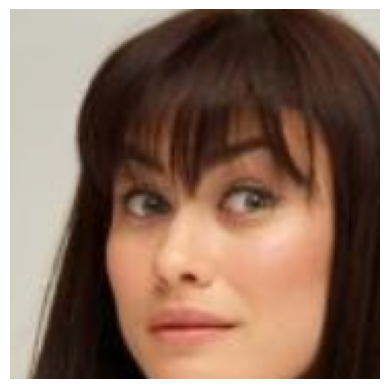

In [14]:
plot_img(test_dataset[0][0])

In [15]:
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True,  num_workers=2)
val_loader   = DataLoader(val_dataset,   batch_size=batch_size, shuffle=False, num_workers=2)
test_loader  = DataLoader(test_dataset,  batch_size=batch_size, shuffle=False, num_workers=2)
loaders = {'train': train_loader, 'valid': val_loader}

## Модель

In [16]:
model = torchvision.models.resnet18(pretrained=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 192MB/s]


In [17]:
n_classes = 500
model.fc = nn.Linear(model.fc.in_features, n_classes)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [18]:
frozen_layers = 1

for i, layer in enumerate(model.children()):
    if i < frozen_layers:
        for param in layer.parameters():
            param.requires_grad = False

In [19]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=0.1)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.8)

In [20]:
def train_loop(model, criterion, optimizer, scheduler, loaders, num_epochs):
    loss_history = {'train': [], 'valid': []}
    acc_history = {'train': [], 'valid': []}

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}')

        for stage, loader in loaders.items():
            epoch_correct = 0
            epoch_all = 0
            train_loss = 0
            val_loss = 0

            for x_batch, y_batch in loader:
                x_batch = x_batch.to(device)
                y_batch = y_batch.to(device)

                if stage == 'train':
                    model.train()
                    optimizer.zero_grad()
                    output = model(x_batch)
                else:
                    model.eval()
                    with torch.no_grad():
                        output = model(x_batch)
                        val_loss = criterion(output, y_batch)

                preds = output.argmax(-1)
                correct = torch.sum(y_batch == preds)
                epoch_correct += correct.item()
                epoch_all += len(y_batch)

                if stage == 'train':
                    train_loss = criterion(output, y_batch)
                    train_loss.backward()
                    optimizer.step()

            loss_epoch = train_loss.item() if stage == 'train' else val_loss.item()
            acc_epoch = epoch_correct / epoch_all
            loss_history[stage].append(loss_epoch)
            acc_history[stage].append(acc_epoch)
            print(f'{stage} loss = {"%.5f" % loss_epoch}, accuracy = {"%.5f" % acc_epoch}')

        scheduler.step()

    return np.arange(num_epochs), loss_history, acc_history

In [21]:
num_epochs = 10
epochs, loss, acc = train_loop(model, criterion, optimizer, scheduler, loaders, num_epochs)

Epoch 1
train loss = 4.17714, accuracy = 0.06191
valid loss = 3.33500, accuracy = 0.13685
Epoch 2
train loss = 2.78385, accuracy = 0.28125
valid loss = 3.25352, accuracy = 0.26464
Epoch 3
train loss = 1.62284, accuracy = 0.60288
valid loss = 2.11801, accuracy = 0.40948
Epoch 4
train loss = 0.84422, accuracy = 0.82350
valid loss = 2.39489, accuracy = 0.44675
Epoch 5
train loss = 0.21949, accuracy = 0.96828
valid loss = 1.08967, accuracy = 0.68424
Epoch 6
train loss = 0.08210, accuracy = 0.99778
valid loss = 0.87257, accuracy = 0.73642
Epoch 7
train loss = 0.02560, accuracy = 0.99953
valid loss = 0.73714, accuracy = 0.74867
Epoch 8
train loss = 0.02204, accuracy = 0.99965
valid loss = 0.74678, accuracy = 0.75186
Epoch 9
train loss = 0.01546, accuracy = 0.99965
valid loss = 0.75585, accuracy = 0.75825
Epoch 10
train loss = 0.01990, accuracy = 0.99965
valid loss = 0.73949, accuracy = 0.75932


In [22]:
def plot_history(epochs, loss, acc):
    fig, ax = plt.subplots(1, 2)

    ax[0].plot(epochs, loss['train'], label='train')
    ax[0].plot(epochs, loss['valid'], label='valid')
    ax[0].set_title('loss')
    ax[0].grid()
    ax[0].legend()

    ax[1].plot(epochs, acc['train'], label='train')
    ax[1].plot(epochs, acc['valid'], label='valid')
    ax[1].set_title('accuracy')
    ax[1].grid()
    ax[1].legend()

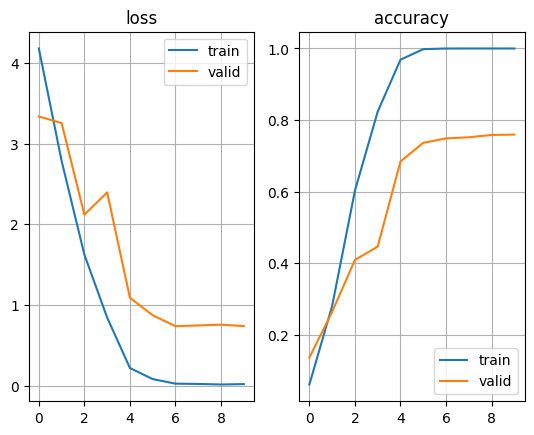

In [23]:
plot_history(epochs, loss, acc)

In [24]:
def calculate_accuracy(model, loader):
    all = 0
    correct = 0

    for x_batch, y_batch in loader:
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)

        model.eval()
        output = model(x_batch)
        preds = output.argmax(-1)
        correct += torch.sum(y_batch == preds)
        all += len(y_batch)

    return correct / all

In [25]:
print(f'test accuracy = {calculate_accuracy(model, test_loader)}')

test accuracy = 0.7564505934715271


## ArcFace loss

ArcFace loss более хитрый чем Cross-Entropy. В нем есть допольнительные гиперпараметры, засчет чего удается добиться, чтобы эмбеддинги одного класса были ближе друг к другу, а эмбеддинги разных классов - дальше друг от друга

In [46]:
class ArcFaceLayer(nn.Module):
    def __init__(self, in_features, out_features, scale, margin):
        super().__init__()
        self.scale = scale
        self.margin = margin
        self.sin_m = torch.sin(torch.tensor(margin))
        self.cos_m = torch.cos(torch.tensor(margin))
        self.out_features = out_features
        self.fc = nn.Linear(in_features, out_features, bias=False)

    def forward(self, x, label=None):
        w_L2 = linalg.norm(self.fc.weight.detach(), dim=1, keepdim=True).T
        x_L2 = linalg.norm(x, dim=1, keepdim=True)
        cos = self.fc(x) / (x_L2 * w_L2)

        if label:
            one_hot = functional.one_hot(label, num_classes=self.out_features)
            sin = (1 - cos ** 2) ** 0.5
            cos_sum = cos * self.cos_m - sin * self.sin_m
            cos = cos_sum * one_hot + cos * (1 - one_hot)
            cos = cos * self.scale

        return cos

In [47]:
class ArcFaceModel(nn.Module):
    def __init__(self, n_classes):
        super().__init__()
        self.n_classes = n_classes
        model = torchvision.models.resnet18(pretrained=True)
        self.base = nn.Sequential(*list(model.children())[:-1])
        self.classifier = ArcFaceLayer(512, self.n_classes, 60, 0.5)

    def forward(self, x, label=None):
        x = self.base(x)
        x = x.view(x.size(0), -1)
        if label:
            return self.classifier(x, label)
        else:
            return self.classifier(x)

In [48]:
arcface_model = ArcFaceModel(n_classes)
arcface_model.to(device)

ArcFaceModel(
  (base): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=Tru

In [49]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(arcface_model.parameters(), lr=3e-4, weight_decay=0.1)
scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=1e-5, max_lr=3e-4, cycle_momentum=False, step_size_up=10)

In [50]:
num_epochs = 100
epochs, loss, acc = train_loop(arcface_model, criterion, optimizer, scheduler, loaders, num_epochs)

Epoch 1
train loss = 6.21223, accuracy = 0.00433
valid loss = 6.19354, accuracy = 0.00586
Epoch 2
train loss = 6.16940, accuracy = 0.02294
valid loss = 6.14853, accuracy = 0.03355
Epoch 3
train loss = 6.10087, accuracy = 0.11845
valid loss = 6.08490, accuracy = 0.11874
Epoch 4
train loss = 6.01841, accuracy = 0.32573
valid loss = 6.01260, accuracy = 0.22897
Epoch 5
train loss = 5.92536, accuracy = 0.55665
valid loss = 5.93889, accuracy = 0.33120
Epoch 6
train loss = 5.87453, accuracy = 0.69967
valid loss = 5.87294, accuracy = 0.40948
Epoch 7
train loss = 5.74373, accuracy = 0.78769
valid loss = 5.81146, accuracy = 0.46219
Epoch 8
train loss = 5.72275, accuracy = 0.84551
valid loss = 5.78188, accuracy = 0.49627
Epoch 9
train loss = 5.67607, accuracy = 0.88951
valid loss = 5.75887, accuracy = 0.48935
Epoch 10
train loss = 5.62712, accuracy = 0.92076
valid loss = 5.72273, accuracy = 0.53621
Epoch 11
train loss = 5.59611, accuracy = 0.93961
valid loss = 5.70260, accuracy = 0.54473
Epoch 12

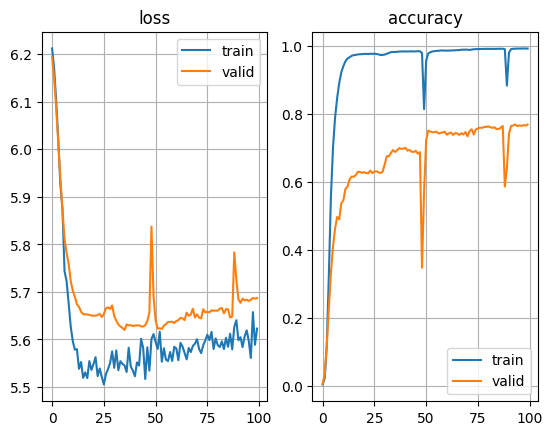

In [51]:
plot_history(epochs, loss, acc)

In [53]:
print(f'test accuracy = {calculate_accuracy(arcface_model, test_loader)}')

test accuracy = 0.7583385705947876
